# CIFAR-10 data explorer

In [18]:
import torch
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import random

from collections import Counter



## Load CIFAR-10

In [19]:
base_dataset = torchvision.datasets.CIFAR10(
    root=".data",
    train=True,
    download=True,
    transform=None  # raw PIL images
)

print(f"Number of training samples: {len(base_dataset)}")
print("Classes:", base_dataset.classes)

tensor_transform = T.ToTensor()  # converts to [0,1] tensor

tensor_dataset = torchvision.datasets.CIFAR10(
    root=".data",
    train=True,
    download=False,
    transform=tensor_transform
)



Number of training samples: 50000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Helper functions

In [20]:
def imshow(img, title=None):
    """Show a single image (tensor or numpy) with optional title."""
    if torch.is_tensor(img):
        img = img.numpy()
        # img: C x H x W → H x W x C
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()



def show_random_grid(dataset, n_rows=4, n_cols=8):
    """Show a grid of random images from the dataset."""
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    
    for i in range(1, n_rows * n_cols + 1):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        plt.subplot(n_rows, n_cols, i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # convert PIL to tensor then to numpy
        if not torch.is_tensor(img):
            img = tensor_transform(img)
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        
        plt.imshow(img_np)
        plt.title(dataset.classes[label], fontsize=8)
    
    plt.tight_layout()
    plt.show()

def compute_mean_std(dataset, num_samples=5000):
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0
    
    for i, (images, _) in enumerate(loader):
        if i * loader.batch_size >= num_samples:
            break
        
        # images: [B, C, H, W]
        b, c, h, w = images.shape
        pixels_in_batch = b * h * w
        
        # reshape to [B, C, H*W]
        images = images.view(b, c, -1)
        
        # mean over batch + spatial dim
        batch_mean = images.mean(dim=(0, 2))
        batch_std = images.std(dim=(0, 2))
        
        mean = (mean * total_pixels + batch_mean * pixels_in_batch) / (total_pixels + pixels_in_batch)
        std = (std * total_pixels + batch_std * pixels_in_batch) / (total_pixels + pixels_in_batch)
        total_pixels += pixels_in_batch
    
    return mean, std



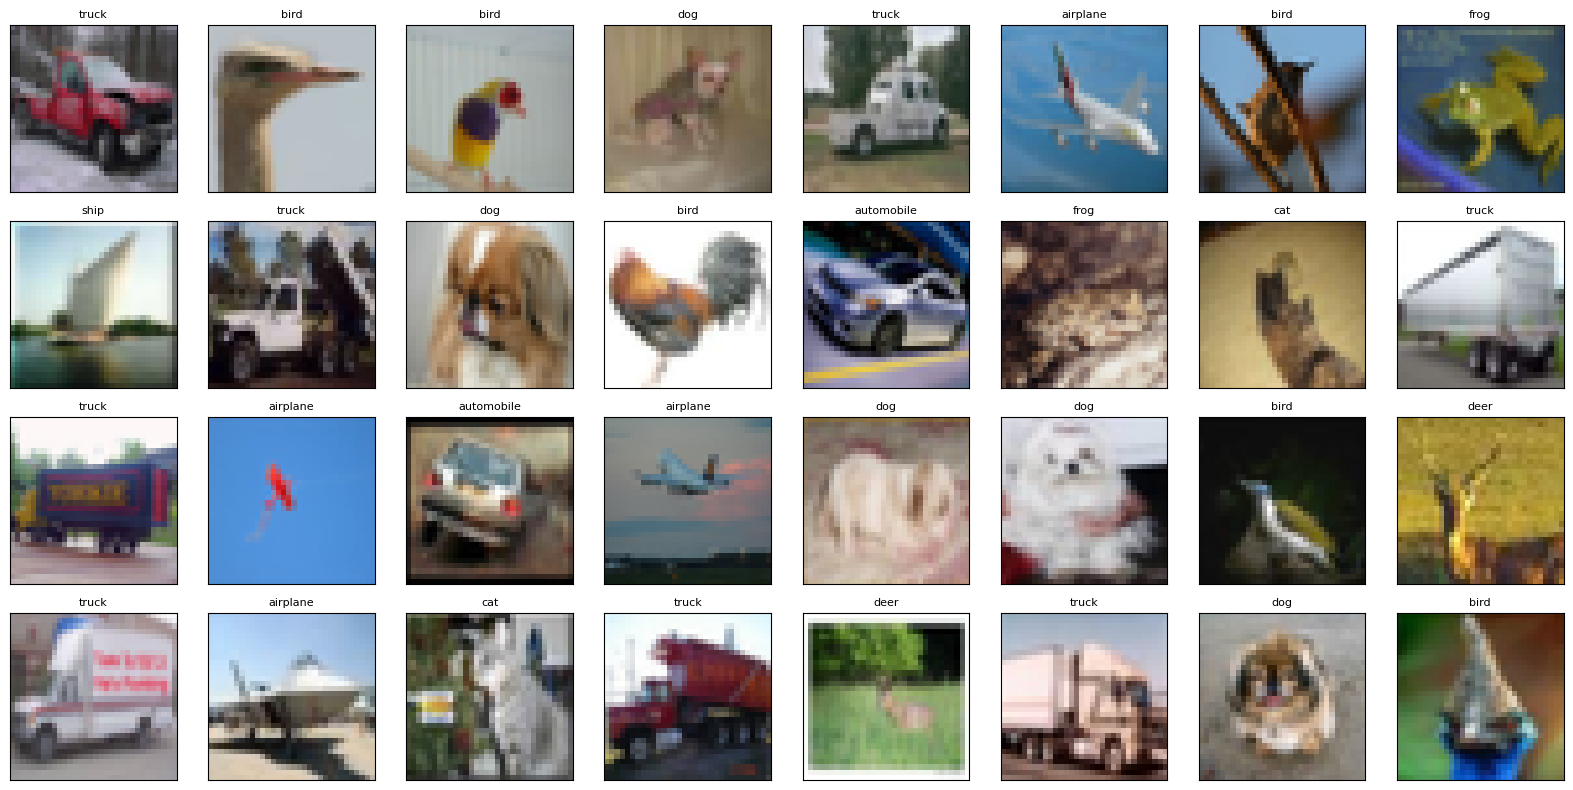

In [21]:
show_random_grid(base_dataset, n_rows=4, n_cols=8)


Counts by class ID: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


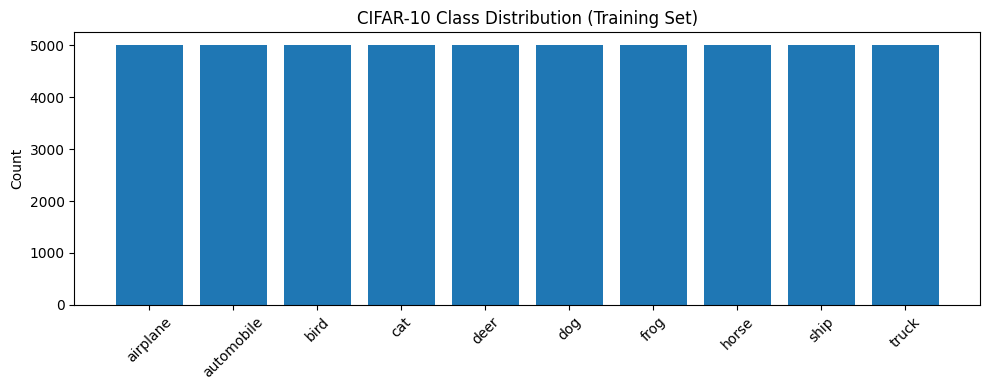

In [22]:

labels = [label for _, label in base_dataset]
label_counts = Counter(labels)

print("Counts by class ID:", label_counts)

# Convert to sorted lists
class_ids = sorted(label_counts.keys())
counts = [label_counts[i] for i in class_ids]
class_names = [base_dataset.classes[i] for i in class_ids]

plt.figure(figsize=(10, 4))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("CIFAR-10 Class Distribution (Training Set)")
plt.tight_layout()
plt.show()


In [23]:

mean, std = compute_mean_std(tensor_dataset, num_samples=5000)
print("Approx. channel-wise mean:", mean)
print("Approx. channel-wise std:", std)


Approx. channel-wise mean: tensor([0.4934, 0.4835, 0.4472])
Approx. channel-wise std: tensor([0.2459, 0.2424, 0.2610])


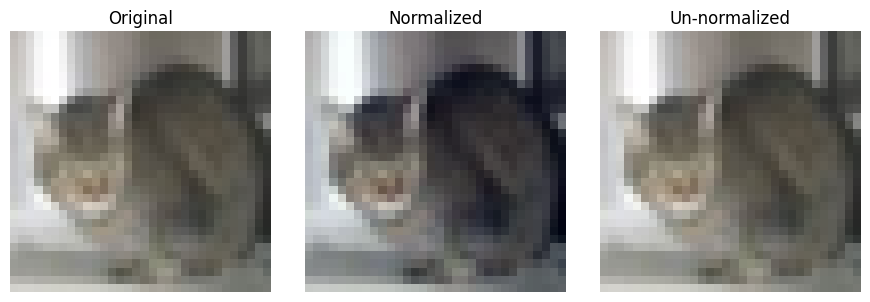

In [47]:
normalize = T.Normalize(mean.tolist(), std.tolist())

# make a dataset with ToTensor and Normalize
norm_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
norm_dataset = torchvision.datasets.CIFAR10(
    root=".data",
    train=True,
    download=False,
    transform=norm_transform
)

idx = random.randint(0, len(base_dataset) - 1)
orig_img_pil, label = base_dataset[idx]
orig_img = tensor_transform(orig_img_pil)
norm_img, _ = norm_dataset[idx]

def to_display_range(t):
    t_min, t_max = t.min(), t.max()
    return (t - t_min) / (t_max - t_min + 1e-8)

orig_img = tensor_transform(orig_img_pil)
norm_img, _ = norm_dataset[idx]

plt.figure(figsize=(9, 3))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.axis("off")
plt.imshow(np.transpose(orig_img.numpy(), (1, 2, 0)))

# Normalized (remapped for display)
plt.subplot(1, 3, 2)
plt.title("Normalized")
plt.axis("off")
norm_vis = to_display_range(norm_img)
plt.imshow(np.transpose(norm_vis.numpy(), (1, 2, 0)))

# Un-normalized (should look like original)
plt.subplot(1, 3, 3)
plt.title("Un-normalized")
plt.axis("off")
norm_display = norm_img * std.view(3, 1, 1) + mean.view(3, 1, 1)
plt.imshow(np.transpose(norm_display.numpy(), (1, 2, 0)))

plt.tight_layout()
plt.show()
